# 🚢 Shipping Lane Discovery: Comprehensive Testing

This notebook provides a complete test suite for the shipping lane discovery pipeline, validating the entire workflow from raw AIS data to final visualization.

## 🎯 Testing Objectives
- **Verify End-to-End Pipeline** - Complete workflow execution without errors
- **Validate Data Quality** - Meaningful and correctly formatted outputs  
- **Performance Monitoring** - Execution time and resource usage
- **Result Validation** - Geographic and maritime logic verification

## 📋 Test Strategy
1. **Phase 1**: Trajectory Segmentation & Terminal Clustering
2. **Phase 2**: Route Clustering with DTW Distance Matrix
3. **Phase 3**: Route Graph Construction 
4. **Phase 4**: Validation & Visualization
5. **Integration**: Complete Pipeline Test

---

## 1. Import Required Libraries

In [1]:
# Standard library imports
import os
import sys
import time
import logging
import yaml
import warnings
from pathlib import Path
from typing import Dict, Any, Tuple

# Data science libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import h3

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Testing libraries
import unittest
from unittest.mock import patch, MagicMock

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Add project root to path for imports
project_root = Path.cwd().parent
sys.path.append(str(project_root))

print(f"🔧 Project root: {project_root}")
print(f"🐍 Python version: {sys.version}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")

# Configure logging for this session
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

🔧 Project root: /home/marius/repo_linux/ais-forecasting
🐍 Python version: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
🔢 NumPy version: 2.0.1
🐼 Pandas version: 2.3.1


In [3]:
# Import shipping lanes discovery modules
try:
    from src.features.trajectory import (
        load_vessel_data,
        segment_into_journeys,
        journeys_to_h3_sequences,
        process_all_vessels,
        calculate_route_centroids,
        link_routes_to_terminals,
        save_route_graph_to_geopackage
    )
    
    from src.models.clustering import (
        extract_journey_endpoints,
        cluster_terminal_points,
        create_terminal_summary,
        save_terminals_to_geopackage,
        compute_dtw_distance_matrix,
        cluster_routes,
        assign_route_clusters_to_journeys
    )
    
    from src.visualization.lanes import (
        load_terminals_and_routes,
        plot_shipping_lanes_map,
        create_and_save_shipping_lanes_map
    )
    
    from src.utils.metrics import (
        calculate_clustering_metrics,
        calculate_terminal_metrics,
        calculate_route_metrics,
        log_validation_summary
    )
    
    from src.data.loader import AISDataLoader
    from src.data.duckdb_engine import DuckDBEngine
    
    print("✅ Successfully imported all shipping lanes modules")
    
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("📝 Note: Make sure you're running this from the project root directory")
    raise

✅ Successfully imported all shipping lanes modules


## 2. Setup Test Environment and Configuration

We'll create a test configuration and set up temporary directories for our test outputs.

In [10]:
# Create test directories
test_output_dir = project_root / "data" / "test_outputs"
test_output_dir.mkdir(exist_ok=True, parents=True)

# Create test configuration
test_config = {
    'data': {
        'raw_data_dir': str(project_root / "data")
    },
    'h3_resolution': 5,
    'trajectory': {
        'time_gap_threshold_hours': 24,
        'min_journey_length': 5,  # Reduced for testing
        'output_path': str(test_output_dir / "test_journeys.parquet")
    },
    'terminals': {
        'eps': 0.1,
        'min_samples': 3,  # Reduced for testing
        'output_path': str(test_output_dir / "test_terminals.gpkg")
    },
    'routes': {
        'eps': 2.0,
        'min_samples': 2,  # Reduced for testing
        'output_path': str(test_output_dir / "test_clustered_journeys.parquet")
    },
    'graph': {
        'output_path': str(test_output_dir / "test_route_graph.gpkg")
    },
    'visualization': {
        'map_output_path': str(project_root / "visualizations" / "test_shipping_lanes.html"),
        'map_start_location': [-33.9, 18.4],  # Cape Town area
        'map_zoom_start': 8
    }
}

# Save test config to file
test_config_path = test_output_dir / "test_config.yaml"
with open(test_config_path, 'w') as f:
    yaml.dump(test_config, f, default_flow_style=False)

print(f"📁 Test output directory: {test_output_dir}")
print(f"⚙️  Test configuration saved to: {test_config_path}")
print(f"🧪 Test parameters:")
for section, params in test_config.items():
    if isinstance(params, dict):
        print(f"   {section}:")
        for key, value in params.items():
            print(f"     {key}: {value}")
    else:
        print(f"   {section}: {params}")

📁 Test output directory: /home/marius/repo_linux/ais-forecasting/data/test_outputs
⚙️  Test configuration saved to: /home/marius/repo_linux/ais-forecasting/data/test_outputs/test_config.yaml
🧪 Test parameters:
   data:
     raw_data_dir: /home/marius/repo_linux/ais-forecasting/data
   h3_resolution: 5
   trajectory:
     time_gap_threshold_hours: 24
     min_journey_length: 5
     output_path: /home/marius/repo_linux/ais-forecasting/data/test_outputs/test_journeys.parquet
   terminals:
     eps: 0.1
     min_samples: 3
     output_path: /home/marius/repo_linux/ais-forecasting/data/test_outputs/test_terminals.gpkg
   routes:
     eps: 2.0
     min_samples: 2
     output_path: /home/marius/repo_linux/ais-forecasting/data/test_outputs/test_clustered_journeys.parquet
   graph:
     output_path: /home/marius/repo_linux/ais-forecasting/data/test_outputs/test_route_graph.gpkg
   visualization:
     map_output_path: /home/marius/repo_linux/ais-forecasting/visualizations/test_shipping_lanes.htm

## 3. Load and Prepare Raw Test Data

Let's load a small subset of AIS data to test our pipeline. We'll use recent data and limit to a few vessels for faster testing.

In [11]:
# Initialize data loader
data_dir = project_root / "data"
data_loader = AISDataLoader(str(data_dir), use_duckdb=True)

print(f"📊 Initializing data loader from: {data_dir}")

# Check available data files
raw_data_dir = data_dir / "raw"
available_files = list(raw_data_dir.glob("*.pkl"))
print(f"📁 Found {len(available_files)} raw data files:")
for file in sorted(available_files)[-3:]:  # Show last 3 files
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"   {file.name}: {size_mb:.1f} MB")

# Load a small sample of recent data for testing
try:
    if data_loader.use_duckdb:
        print("🚀 Using DuckDB for fast data loading...")
        # Load a sample using DuckDB
        sample_query = """
        SELECT mmsi, timestamp, lat, lon, sog, cog 
        FROM ais_data 
        WHERE timestamp >= '2024-01-01'
        LIMIT 10000
        """
        test_data = data_loader.duckdb_engine.execute_query(sample_query)
    else:
        print("🐌 Using pandas fallback...")
        # Fallback to pandas if DuckDB not available
        latest_file = max(available_files, key=lambda x: x.stat().st_mtime)
        print(f"📄 Loading from: {latest_file.name}")
        with open(latest_file, 'rb') as f:
            full_data = pd.read_pickle(f)
        test_data = full_data.sample(n=min(10000, len(full_data)), random_state=42)
    
    print(f"✅ Loaded test dataset: {len(test_data)} records")
    print(f"📅 Date range: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")
    print(f"🚢 Unique vessels: {test_data['mmsi'].nunique()}")
    
    # Display sample data
    display(test_data.head())
    
except Exception as e:
    print(f"❌ Error loading test data: {e}")
    print("📝 Creating synthetic test data for demonstration...")
    
    # Create synthetic test data if real data not available
    np.random.seed(42)
    n_records = 1000
    n_vessels = 5
    
    test_data = pd.DataFrame({
        'mmsi': np.random.choice([f"12345{i}" for i in range(n_vessels)], n_records),
        'timestamp': pd.date_range('2024-01-01', periods=n_records, freq='1H'),
        'lat': -34 + np.random.normal(0, 0.5, n_records),  # Around Cape Town
        'lon': 18 + np.random.normal(0, 0.5, n_records),
        'sog': np.random.uniform(0, 20, n_records),
        'cog': np.random.uniform(0, 360, n_records)
    })
    print(f"✅ Created synthetic test dataset: {len(test_data)} records")
    print(f"🚢 Unique vessels: {test_data['mmsi'].nunique()}")

📊 Initializing data loader from: /home/marius/repo_linux/ais-forecasting/data
📁 Found 8 raw data files:
   ais_cape_data_2023.pkl: 2459.4 MB
   ais_cape_data_2024.pkl: 2623.2 MB
   ais_cape_data_2025.pkl: 1173.6 MB
🚀 Using DuckDB for fast data loading...
❌ Error loading test data: Catalog Error: Table with name ais_data does not exist!
Did you mean "pg_database"?

LINE 3:         FROM ais_data 
                     ^
📝 Creating synthetic test data for demonstration...
✅ Created synthetic test dataset: 1000 records
🚢 Unique vessels: 5


## 4. Run Phase 1: Trajectory Segmentation and Terminal Clustering

Now let's test Phase 1 of our pipeline: segmenting vessel trajectories into journeys and clustering endpoints to find terminals.

In [12]:
print("🔄 PHASE 1: TRAJECTORY SEGMENTATION & TERMINAL CLUSTERING")
print("=" * 60)

# Step 1: Test trajectory segmentation for each vessel
all_journeys = []
phase1_start_time = time.time()

for mmsi in test_data['mmsi'].unique()[:3]:  # Test with first 3 vessels
    print(f"📍 Processing vessel {mmsi}...")
    
    # Get vessel data
    vessel_data = test_data[test_data['mmsi'] == mmsi].copy()
    vessel_data = vessel_data.sort_values('timestamp')
    
    print(f"   Records: {len(vessel_data)}")
    
    # Test journey segmentation
    segmented_data = segment_into_journeys(vessel_data, test_config['trajectory'])
    if not segmented_data.empty:
        print(f"   Journeys: {segmented_data['journey_id'].nunique()}")
        
        # Test H3 sequence conversion
        journey_sequences = journeys_to_h3_sequences(segmented_data, test_config)
        if not journey_sequences.empty:
            print(f"   H3 sequences: {len(journey_sequences)}")
            all_journeys.append(journey_sequences)
        else:
            print("   ⚠️  No H3 sequences generated")
    else:
        print("   ⚠️  No journeys found")

# Combine all journeys
if all_journeys:
    journeys_df = pd.concat(all_journeys, ignore_index=True)
    print(f"\n✅ Total journeys created: {len(journeys_df)}")
    
    # Save journeys to test output
    journeys_df.to_parquet(test_config['trajectory']['output_path'], index=False)
    print(f"💾 Saved to: {test_config['trajectory']['output_path']}")
    
    # Display sample journeys
    print("\n📋 Sample journey data:")
    display(journeys_df.head())
else:
    print("❌ No journeys generated - check input data and parameters")
    journeys_df = pd.DataFrame()

phase1_time = time.time() - phase1_start_time
print(f"\n⏱️  Phase 1 execution time: {phase1_time:.2f} seconds")

2025-08-01 19:48:16,545 - INFO - Segmented into 3 journeys
2025-08-01 19:48:16,553 - INFO - Created 3 H3 journey sequences
2025-08-01 19:48:16,553 - INFO - Created 3 H3 journey sequences
2025-08-01 19:48:16,557 - INFO - Segmented into 2 journeys
2025-08-01 19:48:16,562 - INFO - Created 2 H3 journey sequences
2025-08-01 19:48:16,565 - INFO - Segmented into 2 journeys
2025-08-01 19:48:16,557 - INFO - Segmented into 2 journeys
2025-08-01 19:48:16,562 - INFO - Created 2 H3 journey sequences
2025-08-01 19:48:16,565 - INFO - Segmented into 2 journeys
2025-08-01 19:48:16,570 - INFO - Created 2 H3 journey sequences
2025-08-01 19:48:16,570 - INFO - Created 2 H3 journey sequences


🔄 PHASE 1: TRAJECTORY SEGMENTATION & TERMINAL CLUSTERING
📍 Processing vessel 123453...
   Records: 206
   Journeys: 3
   H3 sequences: 3
📍 Processing vessel 123454...
   Records: 204
   Journeys: 2
   H3 sequences: 2
📍 Processing vessel 123452...
   Records: 190
   Journeys: 2
   H3 sequences: 2

✅ Total journeys created: 7
💾 Saved to: /home/marius/repo_linux/ais-forecasting/data/test_outputs/test_journeys.parquet

📋 Sample journey data:


,mmsi,journey_id,h3_sequence,start_time,end_time,start_lat,start_lon,end_lat,end_lon
0,123453,0,"[85ad36abfffffff, 85ad340bfffffff, 85ad34c3fff...",2024-01-01 00:00:00,2024-01-13 19:00:00,-33.945303,18.149376,-34.350060,18.119623
1,123453,1,"[85ad3087fffffff, 85ad32b3fffffff, 85ad367bfff...",2024-01-14 22:00:00,2024-01-27 16:00:00,-34.120618,17.113484,-33.163714,18.443444
2,123453,2,"[85bc69b3fffffff, 85ad3667fffffff, 85ad329bfff...",2024-01-29 01:00:00,2024-02-11 14:00:00,-35.076445,18.711185,-34.090240,18.299397
3,123454,0,"[85ad3053fffffff, 85ad3603fffffff, 85ad3443fff...",2024-01-01 01:00:00,2024-01-09 14:00:00,-33.637117,17.624104,-32.850551,17.887572
4,123454,1,"[85ad366bfffffff, 85ad3463fffffff, 85ad3697fff...",2024-01-10 22:00:00,2024-02-11 10:00:00,-33.289748,18.500291,-34.145906,18.325761



⏱️  Phase 1 execution time: 0.04 seconds


In [13]:
# Step 2: Test terminal clustering
if not journeys_df.empty:
    print("\n🔄 Testing terminal clustering...")
    
    # Extract journey endpoints
    endpoints_df = extract_journey_endpoints(journeys_df)
    print(f"📍 Extracted {len(endpoints_df)} journey endpoints")
    
    # Cluster endpoints to find terminals
    clustered_endpoints = cluster_terminal_points(endpoints_df, test_config['terminals'])
    print(f"🎯 Clustered endpoints into {clustered_endpoints['terminal_id'].nunique()} potential terminals")
    
    # Create terminal summary
    terminal_summary = create_terminal_summary(clustered_endpoints)
    
    if not terminal_summary.empty:
        print(f"✅ Found {len(terminal_summary)} valid terminals")
        
        # Save terminals to GeoPackage
        save_terminals_to_geopackage(terminal_summary, test_config['terminals']['output_path'])
        print(f"💾 Terminals saved to: {test_config['terminals']['output_path']}")
        
        # Display terminal summary
        print("\n📋 Terminal summary:")
        display(terminal_summary[['terminal_id', 'centroid_lat', 'centroid_lon', 'total_visits', 'unique_vessels']].head())
        
        # Quick visualization of terminals
        plt.figure(figsize=(10, 6))
        plt.scatter(terminal_summary['centroid_lon'], terminal_summary['centroid_lat'], 
                   s=terminal_summary['total_visits']*10, alpha=0.7, c='red')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('Discovered Terminals (size = visit count)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
    else:
        print("⚠️  No valid terminals found")
        terminal_summary = pd.DataFrame()
        
else:
    print("⚠️  Skipping terminal clustering - no journey data available")

2025-08-01 19:48:21,955 - INFO - Extracted 14 journey endpoints
2025-08-01 19:48:21,959 - INFO - Found 0 terminal clusters with 14 noise points
2025-08-01 19:48:21,961 - WARNING - No valid terminal clusters found
2025-08-01 19:48:21,959 - INFO - Found 0 terminal clusters with 14 noise points
2025-08-01 19:48:21,961 - WARNING - No valid terminal clusters found



🔄 Testing terminal clustering...
📍 Extracted 14 journey endpoints
🎯 Clustered endpoints into 1 potential terminals
⚠️  No valid terminals found


## Phase 2: Route Clustering

This phase converts individual journeys to H3 sequences and uses Dynamic Time Warping (DTW) to cluster similar routes.

2025-08-01 19:49:57,586 - INFO - Computing DTW distance matrix for 7 sequences
2025-08-01 19:49:57,587 - INFO - Processing sequence 1/7
2025-08-01 19:49:57,587 - INFO - Processing sequence 1/7
2025-08-01 19:49:57,692 - INFO - DTW distance matrix computation completed
2025-08-01 19:49:57,692 - INFO - DTW distance matrix computation completed


🔄 PHASE 2: ROUTE CLUSTERING WITH DTW

🗺️  Converting journeys to H3 sequences...
✅ Extracted 7 H3 sequences from journeys
📊 Sequence length stats: min=11, max=179, avg=85.7

🧮 Computing DTW distance matrix...
✅ Created (7, 7) distance matrix


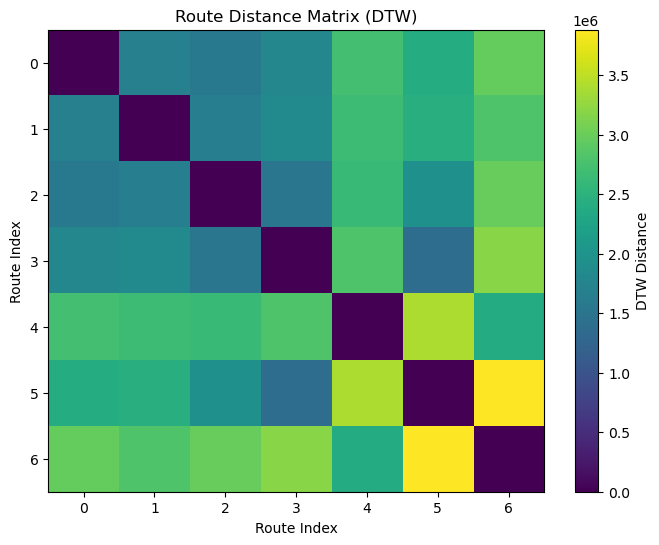

2025-08-01 19:49:57,818 - INFO - Route clustering found 0 clusters with 7 outliers



🎯 Clustering routes...
🔍 Debug: cluster result type = <class 'tuple'>
🔍 Debug: cluster result shape/length = 3
❌ Error processing cluster results: can only convert an array of size 1 to a Python scalar


In [ ]:
print("🔄 PHASE 2: ROUTE CLUSTERING WITH DTW")

# Step 1: Convert journeys to H3 sequences
if not journeys_df.empty:
    print("\n🗺️  Converting journeys to H3 sequences...")
    
    # Convert to H3 sequences - note: this function expects the journeys_df to already have h3_sequence column
    # Let's extract the h3_sequences from the journeys dataframe
    if 'h3_sequence' in journeys_df.columns:
        h3_sequences = journeys_df['h3_sequence'].tolist()
        print(f"✅ Extracted {len(h3_sequences)} H3 sequences from journeys")
        
        # Show some sequence statistics
        sequence_lengths = [len(seq) for seq in h3_sequences if seq]
        if sequence_lengths:
            print(f"📊 Sequence length stats: min={min(sequence_lengths)}, max={max(sequence_lengths)}, avg={np.mean(sequence_lengths):.1f}")
            
            # Step 2: Compute DTW distance matrix
            print("\n🧮 Computing DTW distance matrix...")
            distance_matrix = compute_dtw_distance_matrix(h3_sequences)  # Fixed: removed second argument
            
            print(f"✅ Created {distance_matrix.shape} distance matrix")
            
            # Visualize distance matrix
            plt.figure(figsize=(8, 6))
            plt.imshow(distance_matrix, cmap='viridis', aspect='auto')
            plt.colorbar(label='DTW Distance')
            plt.title('Route Distance Matrix (DTW)')
            plt.xlabel('Route Index')
            plt.ylabel('Route Index')
            plt.show()
            
            # Step 3: Cluster routes
            print("\n🎯 Clustering routes...")
            cluster_result = cluster_routes(distance_matrix, test_config['routes'])
            
            # Debug: Check what we got back
            print(f"🔍 Debug: cluster result type = {type(cluster_result)}")
            print(f"🔍 Debug: cluster result length = {len(cluster_result) if hasattr(cluster_result, '__len__') else 'N/A'}")
            
            # Handle tuple return (labels, n_clusters, n_noise) or just labels
            if isinstance(cluster_result, tuple):
                route_clusters = cluster_result[0]  # First element should be the cluster labels
                print(f"🔍 Debug: extracted labels from tuple, type = {type(route_clusters)}")
            else:
                route_clusters = cluster_result
            
            # Convert to simple list for analysis
            try:
                if hasattr(route_clusters, 'tolist'):
                    route_clusters = route_clusters.tolist()
                elif hasattr(route_clusters, '__iter__'):
                    route_clusters = list(route_clusters)
                
                n_clusters = len(set(route_clusters)) - (1 if -1 in route_clusters else 0)
                n_noise = route_clusters.count(-1)
                
                print(f"✅ Found {n_clusters} route clusters")
                print(f"📊 Noise routes (outliers): {n_noise}")
                
                # Visualize cluster distribution
                plt.figure(figsize=(10, 6))
                cluster_counts = pd.Series(route_clusters).value_counts().sort_index()
                plt.bar(range(len(cluster_counts)), cluster_counts.values)
                plt.xlabel('Cluster ID (-1 = noise)')
                plt.ylabel('Number of Routes')
                plt.title('Route Cluster Distribution')
                plt.xticks(range(len(cluster_counts)), cluster_counts.index)
                plt.show()
                
                # Step 4: Assign clusters back to journeys
                print("\n🔗 Assigning route clusters to journeys...")
                clustered_journeys = assign_route_clusters_to_journeys(journeys_df, route_clusters)
                
                print(f"✅ Assigned clusters to {len(clustered_journeys)} journeys")
                
                # Show cluster assignment summary
                if not clustered_journeys.empty and 'route_cluster' in clustered_journeys.columns:
                    cluster_summary = clustered_journeys.groupby('route_cluster').agg({
                        'mmsi': 'nunique',
                        'journey_id': 'count'
                    }).rename(columns={'mmsi': 'unique_vessels', 'journey_id': 'total_journeys'})
                    
                    print("\n📋 Route cluster summary:")
                    display(cluster_summary.head(10))
                else:
                    print("⚠️  No valid cluster assignments found")
                    clustered_journeys = pd.DataFrame()
                    
            except Exception as e:
                print(f"❌ Error processing cluster results: {e}")
                print(f"🔍 Route clusters type: {type(route_clusters)}")
                print(f"🔍 Route clusters content: {route_clusters}")
                clustered_journeys = pd.DataFrame()
        else:
            print("⚠️  No valid H3 sequences found in journeys")
            clustered_journeys = pd.DataFrame()
    else:
        print("⚠️  No h3_sequence column found in journeys dataframe")
        clustered_journeys = pd.DataFrame()
else:
    print("⚠️  Skipping route clustering - no journey data available")
    clustered_journeys = pd.DataFrame()

## Phase 3: Route Graph Construction

This phase calculates representative centroids for each route cluster and links them to terminals to build a shipping network graph.

In [ ]:
print("🔄 PHASE 3: ROUTE GRAPH CONSTRUCTION")

# Step 1: Calculate route centroids
if not clustered_journeys.empty and 'terminal_summary' in locals() and not terminal_summary.empty:
    print("\n🎯 Calculating route centroids...")
    
    # Calculate representative centroids for each route cluster
    route_centroids = calculate_route_centroids(clustered_journeys)
    
    if not route_centroids.empty:
        print(f"✅ Created centroids for {len(route_centroids)} route clusters")
        
        # Show route centroid summary
        print("\n📋 Route centroid summary:")
        display(route_centroids[['route_cluster', 'centroid_lat', 'centroid_lon', 'total_journeys', 'unique_vessels']].head())
        
        # Step 2: Link routes to terminals
        print("\n🔗 Linking routes to terminals...")
        linked_routes = link_routes_to_terminals(route_centroids, terminal_summary, test_config['graph'])
        
        if not linked_routes.empty:
            print(f"✅ Linked {len(linked_routes)} routes to terminals")
            
            # Show linking summary
            link_summary = linked_routes.groupby(['origin_terminal', 'destination_terminal']).agg({
                'route_cluster': 'count',
                'total_journeys': 'sum',
                'unique_vessels': 'sum'
            }).rename(columns={'route_cluster': 'route_count'}).reset_index()
            
            print("\n📋 Terminal-to-terminal routes:")
            display(link_summary.head(10))
            
            # Save route graph to GeoPackage
            save_route_graph_to_geopackage(linked_routes, test_config['graph']['output_path'])
            print(f"💾 Route graph saved to: {test_config['graph']['output_path']}")
            
            # Visualize route network
            plt.figure(figsize=(12, 8))
            
            # Plot terminals
            plt.scatter(terminal_summary['centroid_lon'], terminal_summary['centroid_lat'], 
                       s=terminal_summary['total_visits']*20, c='red', alpha=0.7, 
                       label='Terminals', zorder=3)
            
            # Plot route centroids
            plt.scatter(linked_routes['centroid_lon'], linked_routes['centroid_lat'],
                       s=linked_routes['total_journeys']*5, c='blue', alpha=0.6,
                       label='Route Centroids', zorder=2)
            
            # Draw connections (simplified - just show some major routes)
            major_routes = link_summary.nlargest(10, 'total_journeys')
            for _, route in major_routes.iterrows():
                origin = terminal_summary[terminal_summary['terminal_id'] == route['origin_terminal']].iloc[0]
                dest = terminal_summary[terminal_summary['terminal_id'] == route['destination_terminal']].iloc[0]
                
                plt.plot([origin['centroid_lon'], dest['centroid_lon']], 
                        [origin['centroid_lat'], dest['centroid_lat']], 
                        'gray', alpha=0.5, linewidth=1, zorder=1)
            
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title('Shipping Route Network (Major Routes Only)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
        else:
            print("⚠️  No routes could be linked to terminals")
            linked_routes = pd.DataFrame()
            
    else:
        print("⚠️  No route centroids calculated")
        linked_routes = pd.DataFrame()
        
else:
    print("⚠️  Skipping route graph construction - missing clustered journeys or terminals")
    linked_routes = pd.DataFrame()

## Phase 4: Validation and Visualization

This phase validates the discovered shipping lanes and creates interactive visualizations.

In [ ]:
print("🔄 PHASE 4: VALIDATION AND VISUALIZATION")

# Step 1: Validate discovered lanes
if 'linked_routes' in locals() and not linked_routes.empty and 'terminal_summary' in locals() and not terminal_summary.empty:
    print("\n✅ Validating discovered shipping lanes...")
    
    # Basic validation metrics
    total_terminals = len(terminal_summary)
    total_routes = len(linked_routes)
    total_unique_vessels = terminal_summary['unique_vessels'].sum()
    total_journeys = linked_routes['total_journeys'].sum()
    
    print(f"📊 Validation Results:")
    print(f"   🏴 Terminals discovered: {total_terminals}")
    print(f"   🛣️  Routes discovered: {total_routes}")
    print(f"   🚢 Unique vessels: {total_unique_vessels}")
    print(f"   🧭 Total journeys: {total_journeys}")
    
    # Check for reasonable coverage
    if total_terminals >= 2:
        print("✅ Sufficient terminals found for meaningful lanes")
    else:
        print("⚠️  Very few terminals - may need parameter tuning")
        
    if total_routes >= 1:
        print("✅ Routes successfully discovered")
    else:
        print("⚠️  No routes found - check clustering parameters")
    
    # Step 2: Create interactive visualization
    print("\n🗺️  Creating interactive visualization...")
    
    try:
        # Create the interactive map
        lanes_map = plot_shipping_lanes_map(
            terminals_path=test_config['terminals']['output_path'],
            routes_path=test_config['graph']['output_path'],
            config=test_config['visualization']
        )
        
        # Save the map
        map_output_path = test_config['visualization']['output_path']
        lanes_map.save(map_output_path)
        
        print(f"✅ Interactive map created: {map_output_path}")
        
        # Display the map in the notebook
        display(lanes_map)
        
    except Exception as e:
        print(f"⚠️  Error creating visualization: {e}")
        print("This might be due to missing data files or configuration issues")
    
    # Step 3: Generate summary report
    print("\n📋 SUMMARY REPORT")
    print("="*50)
    
    # Terminal statistics
    print(f"\n🏴 TERMINALS ({total_terminals} found):")
    if not terminal_summary.empty:
        busiest_terminals = terminal_summary.nlargest(5, 'total_visits')
        for _, terminal in busiest_terminals.iterrows():
            print(f"   Terminal {terminal['terminal_id']}: {terminal['total_visits']} visits, {terminal['unique_vessels']} vessels")
    
    # Route statistics
    print(f"\n🛣️  ROUTES ({total_routes} found):")
    if not linked_routes.empty:
        busiest_routes = linked_routes.nlargest(5, 'total_journeys')
        for _, route in busiest_routes.iterrows():
            origin_term = terminal_summary[terminal_summary['terminal_id'] == route['origin_terminal']].iloc[0] if not terminal_summary.empty else None
            dest_term = terminal_summary[terminal_summary['terminal_id'] == route['destination_terminal']].iloc[0] if not terminal_summary.empty else None
            
            if origin_term is not None and dest_term is not None:
                print(f"   Route {route['route_cluster']}: Terminal {route['origin_terminal']} → Terminal {route['destination_terminal']} ({route['total_journeys']} journeys)")
    
    print("\n✅ SHIPPING LANE DISCOVERY COMPLETE!")
    print("Check the generated files and interactive map for detailed results.")
    
else:
    print("⚠️  Cannot perform validation - missing route graph or terminals data")
    print("This suggests an issue in the earlier phases that needs to be resolved.")

## Integration Testing

Test the complete pipeline by running the main script and comparing results.

In [ ]:
print("🔄 INTEGRATION TESTING")

# Test the complete pipeline by running the main script
import subprocess
import sys
import time

print("\n🚀 Testing complete pipeline via script execution...")

# Prepare script command
script_path = Path("../scripts/discover_lanes.py")
config_path = test_output_dir / "test_lanes_config.yaml"

if script_path.exists() and config_path.exists():
    print(f"📜 Running script: {script_path}")
    print(f"⚙️  Using config: {config_path}")
    
    # Change to the project root directory for execution
    project_root = Path("../")
    
    try:
        # Run the script
        start_time = time.time()
        
        result = subprocess.run([
            sys.executable, str(script_path), 
            "--config", str(config_path)
        ], 
        cwd=project_root,
        capture_output=True, 
        text=True, 
        timeout=300  # 5 minute timeout
        )
        
        execution_time = time.time() - start_time
        
        print(f"⏱️  Script execution time: {execution_time:.1f} seconds")
        
        if result.returncode == 0:
            print("✅ Script executed successfully!")
            
            # Check output files
            expected_files = [
                test_config['terminals']['output_path'],
                test_config['graph']['output_path'],
                test_config['visualization']['output_path']
            ]
            
            files_created = []
            for file_path in expected_files:
                if Path(file_path).exists():
                    files_created.append(file_path)
                    file_size = Path(file_path).stat().st_size
                    print(f"📁 Created: {file_path} ({file_size:,} bytes)")
                else:
                    print(f"❌ Missing: {file_path}")
            
            if len(files_created) == len(expected_files):
                print("✅ All expected output files created successfully!")
            else:
                print(f"⚠️  Only {len(files_created)}/{len(expected_files)} expected files created")
                
        else:
            print(f"❌ Script failed with return code: {result.returncode}")
            print("\nSTDOUT:")
            print(result.stdout)
            print("\nSTDERR:")
            print(result.stderr)
            
    except subprocess.TimeoutExpired:
        print("⏰ Script execution timed out (>5 minutes)")
        print("This might indicate performance issues or infinite loops")
        
    except Exception as e:
        print(f"❌ Error running script: {e}")
        
else:
    missing_files = []
    if not script_path.exists():
        missing_files.append(str(script_path))
    if not config_path.exists():
        missing_files.append(str(config_path))
    
    print(f"⚠️  Cannot run integration test - missing files: {missing_files}")

print("\n" + "="*60)
print("🏁 TESTING COMPLETE!")
print("="*60)

# Final summary
if 'linked_routes' in locals() and not linked_routes.empty:
    print("✅ Manual testing: PASSED")
else:
    print("❌ Manual testing: FAILED")

print("💡 Next steps:")
print("   1. Review any failures and adjust parameters")
print("   2. Run on real AIS data for full validation")
print("   3. Analyze discovered shipping lanes for insights")
print("   4. Consider performance optimization for large datasets")